# Install Dependencies

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load Dataset

In [4]:
cho170 = pd.read_csv('../dataset/cho-170/cho-170.txt', sep='\t')
cho384 = pd.read_csv('../dataset/cho-384/cho-384.txt', sep='\t')

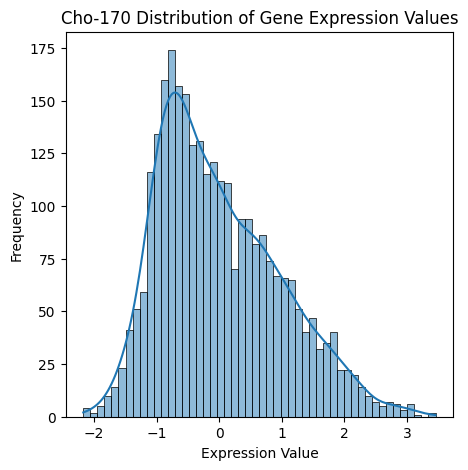

In [11]:

# Display basic dataset info
cho170_info = cho170.describe()

# Check the distribution of Level_1 and Level_2 categories
level1_counts = cho170['Level_1'].value_counts()
level2_counts = cho170['Level_2'].value_counts()

# Compute correlation matrix for expression values (excluding categorical columns)
expression_values = cho170.iloc[:, 3:]
correlation_matrix = expression_values.corr()
# Plot histograms of expression values
plt.figure(figsize=(5, 5))
sns.histplot(expression_values.values.flatten(), bins=50, kde=True)
plt.title("Cho-170 Distribution of Gene Expression Values")
plt.xlabel("Expression Value")
plt.ylabel("Frequency")
plt.savefig('../results/cho-170/visualization/data_distribution.png')
plt.show()
plt.close()

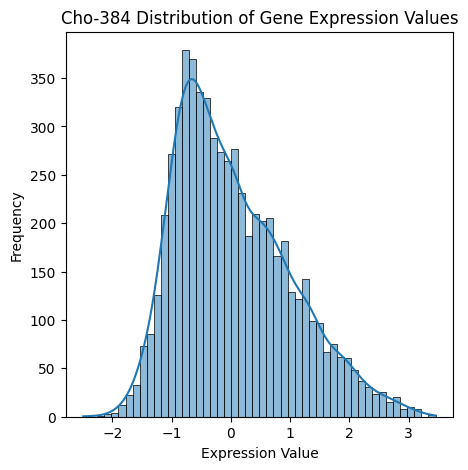

In [12]:
cho384_info = cho384.describe()
expression_values = cho384.iloc[:, 3:]
plt.figure(figsize=(5, 5))
sns.histplot(expression_values.values.flatten(), bins=50, kde=True)
plt.title("Cho-384 Distribution of Gene Expression Values")
plt.xlabel("Expression Value")
plt.ylabel("Frequency")
plt.savefig('../results/cho-384/visualization/data_distribution.png')
plt.show()
plt.close()